# **Detecta Placa de Carros de Imagens ou Camera**
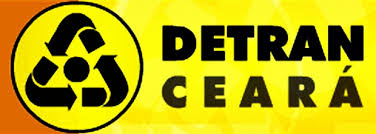

In [0]:
!nvidia-smi

In [0]:
!git clone https://github.com/fizyr/keras-retinanet.git

In [0]:
!pip install --upgrade keras

In [0]:
%cd keras-retinanet/

!pip install .

In [0]:
!python setup.py build_ext --inplace

In [0]:
!pip install gdown
!pip install tensorflow-gpu

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [0]:
!gdown --id 1mTtB8GTWs74Yeqm0KMExGJZh1eDbzUlT --output indian_number_plates.json

In [0]:
os.makedirs("snapshots", exist_ok=True)

## **Baixa as imagens dos carros para treinar a Rede Neural**

In [0]:
!gdown --id 1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R --output snapshots/resnet50_csv_10.h5

In [0]:
plates_df = pd.read_json('indian_number_plates.json', lines=True)

In [0]:
os.makedirs("number_plates", exist_ok=True)

In [13]:
dataset = dict()
dataset["image_name"] = list()
dataset["x_min"] = list()
dataset["y_min"] = list()
dataset["x_max"] = list()
dataset["y_max"] = list()
dataset["class_name"] = list()

counter = 0
for index, row in plates_df.iterrows():
    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert('RGB')
    img.save(f'number_plates/licensed_car_{counter}.jpeg', "JPEG")
    
    dataset["image_name"].append(f'number_plates/licensed_car_{counter}.jpeg')
    
    data = row["annotation"]
  
    width = data[0]["imageWidth"]
    height = data[0]["imageHeight"]

    dataset["x_min"].append(int(round(data[0]["points"][0]["x"] * width)))
    dataset["y_min"].append(int(round(data[0]["points"][0]["y"] * height)))
    dataset["x_max"].append(int(round(data[0]["points"][1]["x"] * width)))
    dataset["y_max"].append(int(round(data[0]["points"][1]["y"] * height)))
    dataset["class_name"].append("license_plate")
    
    counter += 1
print("Downloaded {} car images.".format(counter))

Downloaded 237 car images.


In [0]:
df = pd.DataFrame(dataset)
df.head()

In [0]:
def show_image_objects(image_row):

  img_path = image_row.image_name
  box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]

  image = read_image_bgr(img_path)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  draw_box(draw, box, color=(255, 255, 0))

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

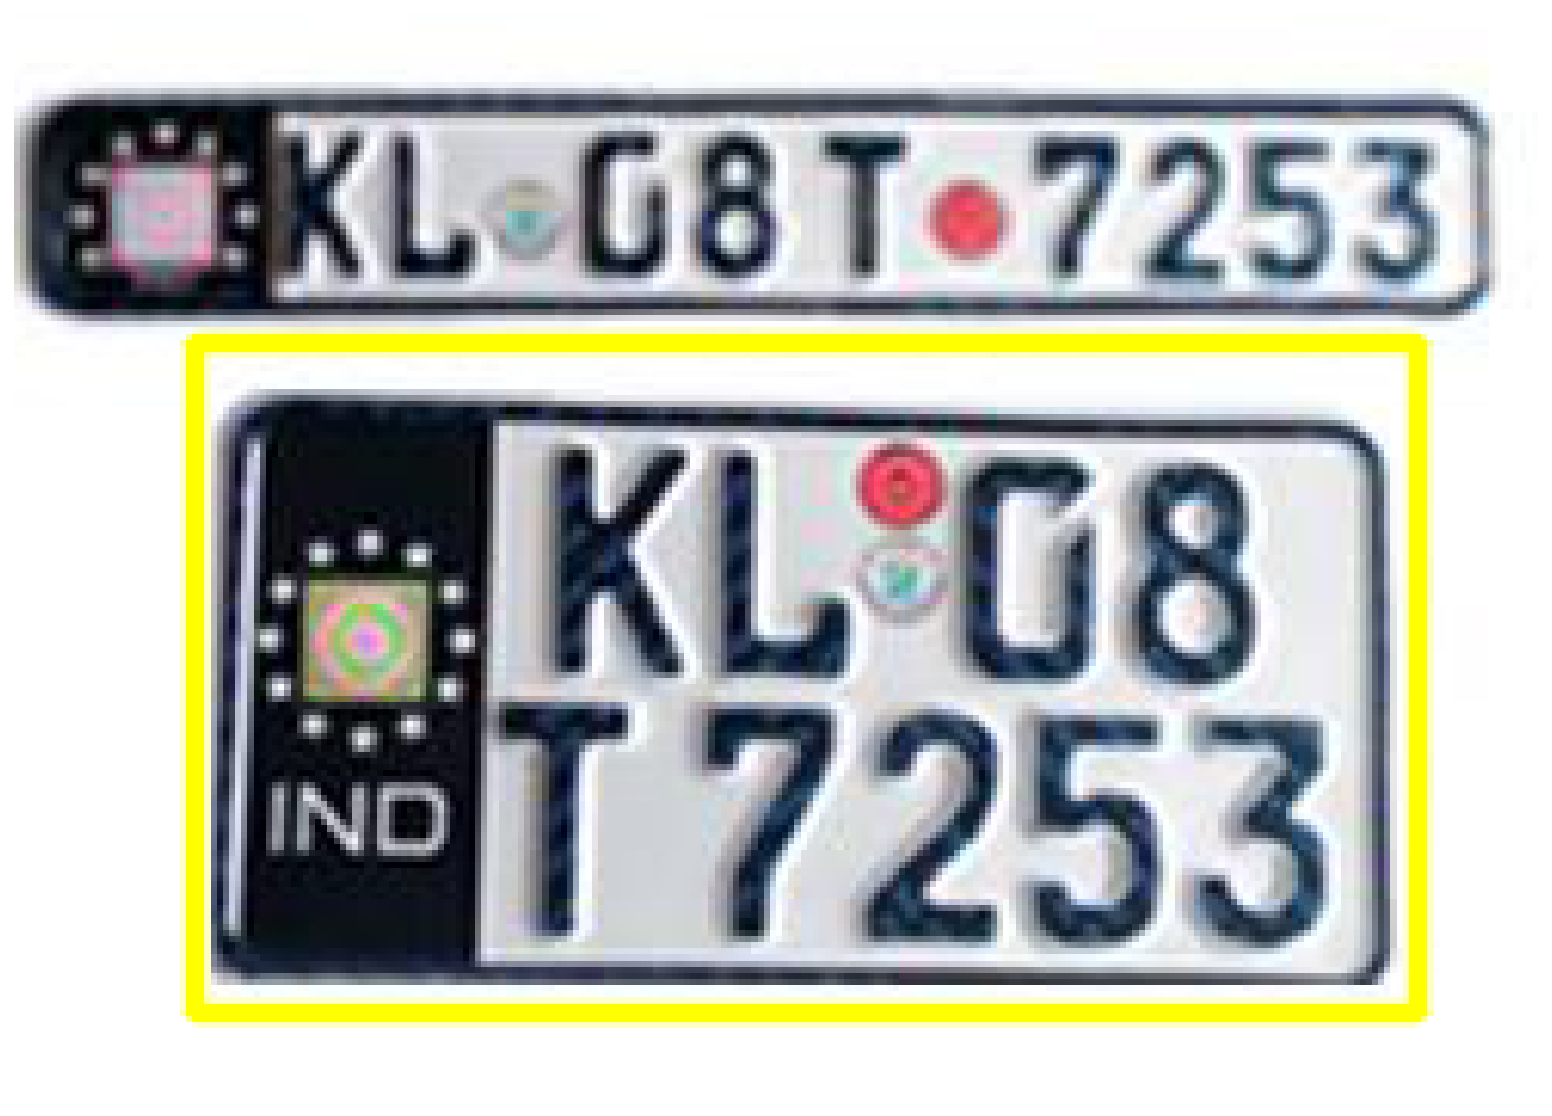

In [67]:
show_image_objects(df.iloc[100]) # usar 30% para teste

## Pre processamento das Imagens

In [0]:
train_df, test_df = train_test_split(
  df, 
  test_size=0.2, 
  random_state=RANDOM_SEED
)

In [0]:
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [0]:
train_df.to_csv(ANNOTATIONS_FILE, index=False, header=None)

In [0]:
classes = set(['license_plate'])

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(sorted(classes)):
    f.write('{},{}\n'.format(line,i))

In [0]:
!head classes.csv

license_plate,0


In [24]:
!head annotations.csv

head: cannot open 'annotations.csv' for reading: No such file or directory


## **Treinamento** das Imagens na Rede Neural, usando COCO

In [0]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

In [0]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 500 --epochs 10 csv annotations.csv classes.csv

## Carrega o modelo ja treinado

In [0]:
!ls snapshots

In [0]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

# **Predição** da Rede Neural

In [0]:
def predict(image):
  image = preprocess_image(image.copy())
  image, scale = resize_image(image)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(image, axis=0)
  )

  boxes /= scale

  return boxes, scores, labels

In [0]:
THRES_SCORE = 0.6

def draw_detections(image, boxes, scores, labels):
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < THRES_SCORE:
        break

    color = label_color(label)

    b = box.astype(int)
    draw_box(image, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)


In [0]:
def show_detected_objects(image_row):
  img_path = image_row.image_name
  
  image = read_image_bgr(img_path)

  boxes, scores, labels = predict(image)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  true_box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]
  draw_box(draw, true_box, color=(255, 255, 0))

  draw_detections(draw, boxes, scores, labels)

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

In [0]:
test_df.head(n=10)

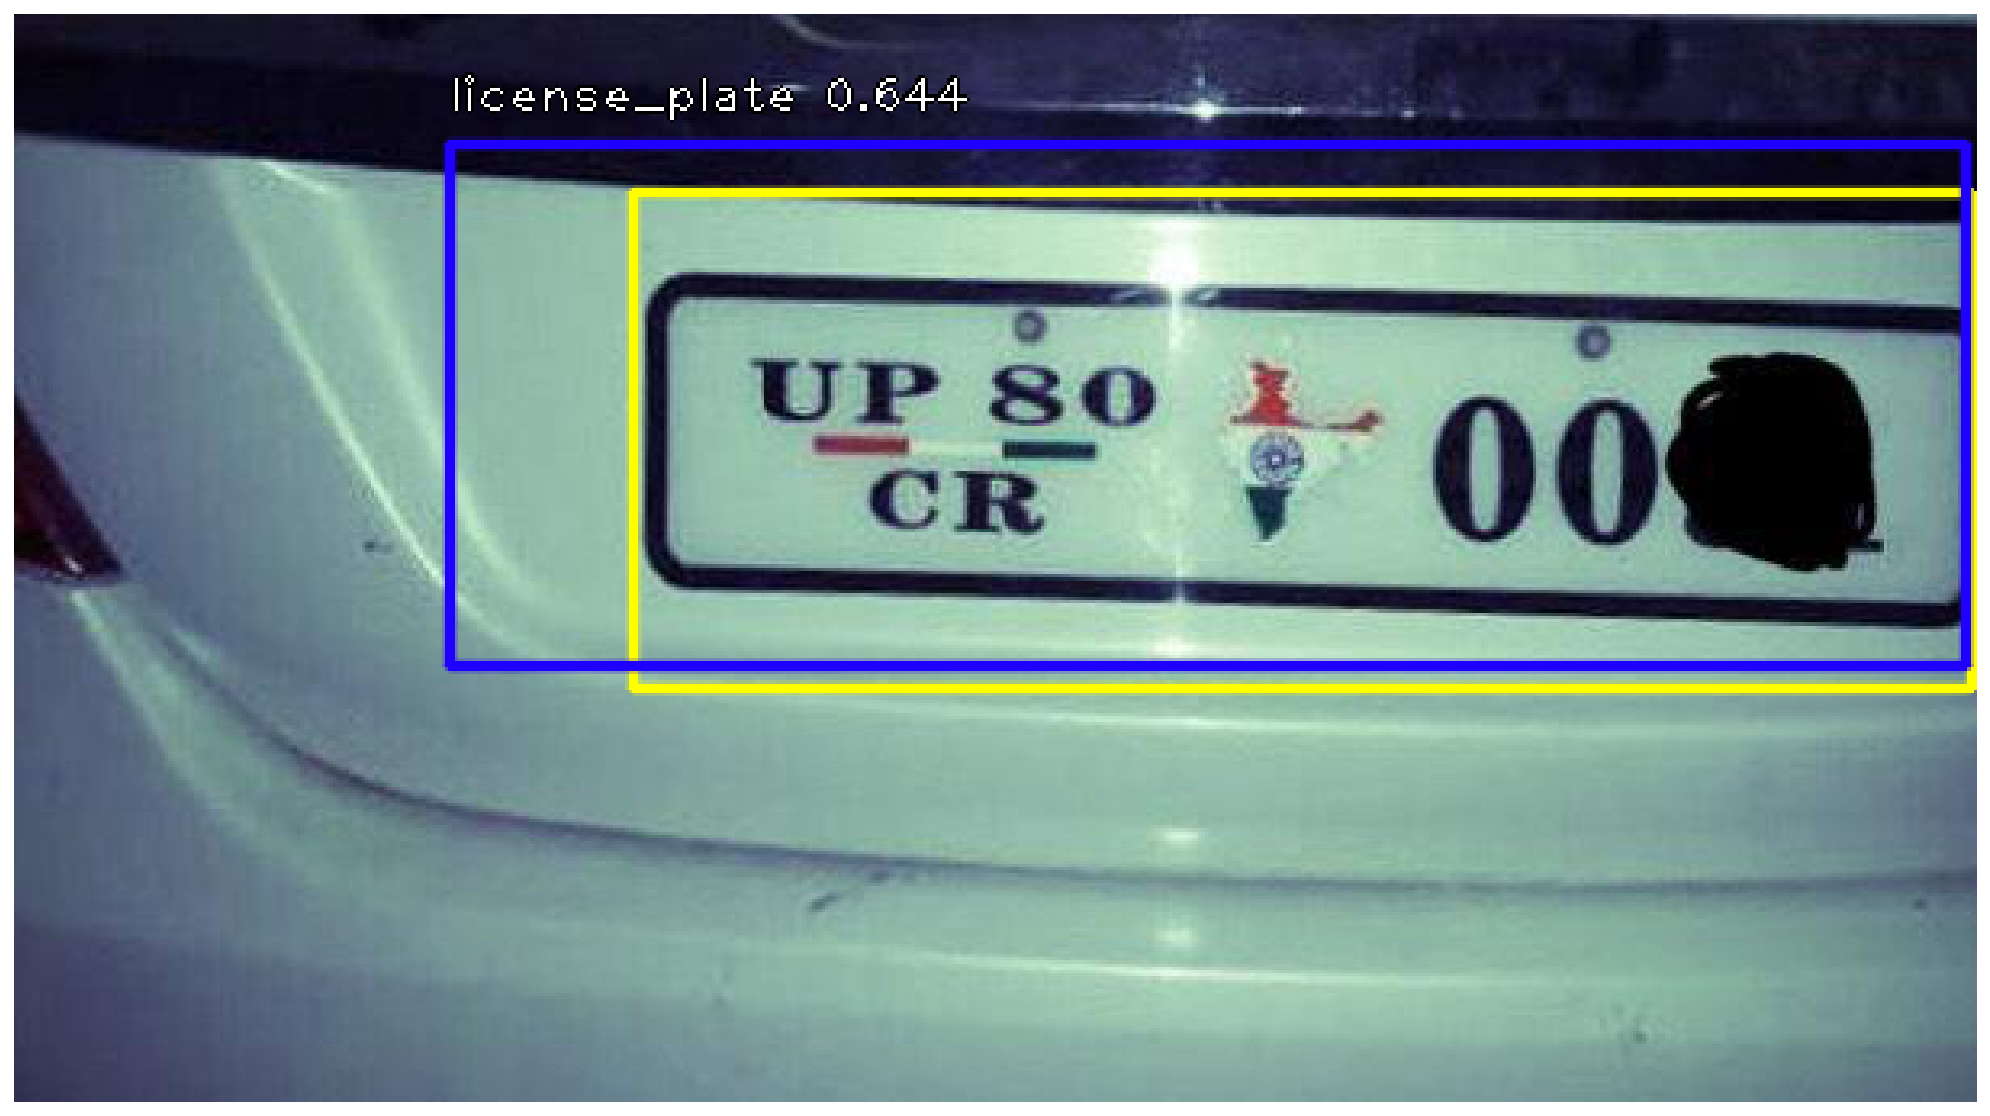

In [74]:
show_detected_objects(test_df.iloc[47]) # A rede ja treinada , sobrando 70%, ao eu mandar ele analisar uma imagem, ele acha a placa